In [ ]:
!pip install --force-reinstall \
    numpy==1.26.4 \
    pillow==10.4.0 \
    requests==2.32.4 \
    pandas==2.2.2 \
    matplotlib==3.7.1 \
    scikit-learn==1.4.2 \
    wfdb==4.1.2


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wfdb-4.1.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached charset_normalizer-3.4.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (37 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.1-py3-none-any.whl.metadata (6.6 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-

In [ ]:
import numpy as np, pandas as pd, PIL, requests
import tensorflow as tf

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("pillow:", PIL.__version__)
print("requests:", requests.__version__)
print("tensorflow:", tf.__version__)


numpy: 1.26.4
pandas: 2.2.2
pillow: 10.4.0
requests: 2.32.4
tensorflow: 2.19.0


In [ ]:
import pandas
print(pandas.__version__)


2.2.2


In [ ]:
import os

BASE_DIR = "/content"
DATA_PATH = os.path.join(BASE_DIR, "mitdb")

os.makedirs(DATA_PATH, exist_ok=True)

# Download all records (about 70–80 MB)
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/ -P $BASE_DIR

# Move files into /content/mitdb for convenience
!cp -n -v /content/physionet.org/files/mitdb/1.0.0/* $DATA_PATH

!ls $DATA_PATH | head


Streaming output truncated to the last 5000 lines.
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 162 [text/plain]
Saving to: ‘/content/physionet.org/files/mitdb/1.0.0/233.hea’

physionet.org/files 100%[===================>]     162  --.-KB/s    in 0s      

2025-12-09 20:57:26 (45.6 MB/s) - ‘/content/physionet.org/files/mitdb/1.0.0/233.hea’ saved [162/162]

--2025-12-09 20:57:26--  https://physionet.org/files/mitdb/1.0.0/233.xws
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 88 [text/plain]
Saving to: ‘/content/physionet.org/files/mitdb/1.0.0/233.xws’

physionet.org/files 100%[===================>]      88  --.-KB/s    in 0s      

2025-12-09 20:57:26 (31.4 MB/s) - ‘/content/physionet.org/files/mitdb/1.0.0/233.xws’ saved [88/88]

--2025-12-09 20:57:26--  https://physionet.org/files/mitdb/1.0.0/234.atr
Reusing existing connection to physionet.org:443.
HTTP request sent, a

In [ ]:
import wfdb
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import random

DATA_PATH = "/content/mitdb"
SEG_LEN = 256            # 128 before + 128 after R-peak
HALF = SEG_LEN // 2
NORMAL_LABELS = ["N"]    # treat only 'N' as normal; everything else = arrhythmia

def process_record(record_name, data_path=DATA_PATH, seg_len=SEG_LEN, half=HALF):
    """
    Returns:
      X_rec: (num_segments, seg_len, 1)
      y_rec: (num_segments,)
    """
    record_path = os.path.join(data_path, record_name)

    # read signal (use lead 0)
    signal, fields = wfdb.rdsamp(record_path)
    signal = signal[:, 0]
    n_samples = len(signal)

    # read annotations
    ann = wfdb.rdann(record_path, "atr")
    r_peaks = ann.sample
    symbols = ann.symbol

    segments = []
    labels = []

    for r, sym in zip(r_peaks, symbols):
        # skip if too close to edges
        if r - half < 0 or r + half >= n_samples:
            continue

        seg = signal[r - half : r + half]
        # basic sanity
        if len(seg) != seg_len:
            continue

        # binary label: 0 = normal, 1 = arrhythmia
        y_bin = 0 if sym in NORMAL_LABELS else 1

        segments.append(seg)
        labels.append(y_bin)

    if len(segments) == 0:
        return None, None

    X_rec = np.array(segments, dtype=np.float32)
    y_rec = np.array(labels, dtype=np.int64)

    # normalize each segment: zero mean, unit std
    X_rec = X_rec.reshape(-1, seg_len, 1)
    X_rec = (X_rec - X_rec.mean(axis=1, keepdims=True)) / (X_rec.std(axis=1, keepdims=True) + 1e-8)

    return X_rec, y_rec


# ---------- build dataset across records, split by record ----------

# get all record names (strip .dat)
all_dat_files = sorted(glob.glob(os.path.join(DATA_PATH, "*.dat")))
record_names = [os.path.splitext(os.path.basename(f))[0] for f in all_dat_files]

print("Found records:", record_names)

# split records into train/val/test (70/15/15) – record-level split
random.seed(42)
random.shuffle(record_names)

n = len(record_names)
n_train = int(0.7 * n)
n_val = int(0.15 * n)

train_records = record_names[:n_train]
val_records   = record_names[n_train:n_train + n_val]
test_records  = record_names[n_train + n_val:]

print("Train records:", train_records)
print("Val records:", val_records)
print("Test records:", test_records)

def build_split(records):
    X_list, y_list = [], []
    for rec in records:
        print(f"Processing record {rec} ...")
        X_rec, y_rec = process_record(rec)
        if X_rec is None:
            print(f"  Skipped {rec} (no valid segments)")
            continue
        X_list.append(X_rec)
        y_list.append(y_rec)
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = build_split(train_records)
X_val,   y_val   = build_split(val_records)
X_test,  y_test  = build_split(test_records)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

# save .npy files (for train.py style later if you want)
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy",   X_val)
np.save("y_val.npy",   y_val)
np.save("X_test.npy",  X_test)
np.save("y_test.npy",  y_test)


Found records: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Train records: ['208', '200', '201', '111', '123', '109', '209', '221', '113', '103', '215', '104', '230', '203', '112', '213', '207', '223', '119', '210', '233', '212', '217', '202', '122', '124', '234', '231', '100', '121', '117', '228', '114']
Val records: ['220', '232', '102', '205', '219', '105', '214']
Test records: ['106', '108', '115', '116', '118', '101', '107', '222']
Processing record 208 ...
Processing record 200 ...
Processing record 201 ...
Processing record 111 ...
Processing record 123 ...
Processing record 109 ...
Processing record 209 ...
Processing record 221 ...
Processing record 113 ...
Processing record 103 ...
Process

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]  # (SEG_LEN, 1)

def build_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=5, activation="relu", padding="same")(inputs)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="cnn_ecg")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, time, features)
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)   # (batch, time, 1)
        a = tf.nn.softmax(e, axis=1)                      # attention weights
        context = tf.reduce_sum(a * inputs, axis=1)       # (batch, features)
        return context, tf.squeeze(a, axis=-1)


def build_bilstm_attention_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)

    context, att_weights = AttentionLayer(name="attention")(x)

    x = layers.Dense(64, activation="relu")(context)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="bilstm_attention_ecg")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    # separate model to get attention weights for plotting
    att_model = models.Model(inputs, att_weights, name="attention_weights_model")

    return model, att_model


In [ ]:
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_class_weights(y):
    classes = np.unique(y)
    w = class_weight.compute_class_weight(
        class_weight="balanced", classes=classes, y=y
    )
    return dict(zip(classes, w))

def evaluate_keras_model(model, X, y):
    y_prob = model.predict(X, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average="binary")
    return acc, prec, rec, f1


class_weights = compute_class_weights(y_train)
print("Class weights:", class_weights)

# ---- Train CNN ----
cnn_model = build_cnn_model(input_shape)
print(cnn_model.summary())

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    class_weight=class_weights,
    verbose=2
)

acc, prec, rec, f1 = evaluate_keras_model(cnn_model, X_test, y_test)
print(f"CNN Test - Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")

cnn_model.save("cnn_ecg.h5")

# ---- Train BiLSTM + Attention ----
bilstm_model, att_model = build_bilstm_attention_model(input_shape)
print(bilstm_model.summary())

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

acc, prec, rec, f1 = evaluate_keras_model(bilstm_model, X_test, y_test)
print(f"BiLSTM+Att Test - Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")

bilstm_model.save("bilstm_attention_ecg.h5")
att_model.save("attention_weights_model.h5")


Class weights: {0: 0.7290291137145274, 1: 1.5915642816991888}


Model: "cnn_ecg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,769 (1.04 MB)

 Trainable params: 272,769 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
1239/1239 - 43s - 34ms/step - accuracy: 0.9684 - loss: 0.1098 - val_accuracy: 0.9161 - val_loss: 0.2672
Epoch 2/15
1239/1239 - 40s - 32ms/step - accuracy: 0.9827 - loss: 0.0671 - val_accuracy: 0.8676 - val_loss: 0.3541
Epoch 3/15
1239/1239 - 40s - 33ms/step - accuracy: 0.9852 - loss: 0.0574 - val_accuracy: 0.9167 - val_loss: 0.2696
Epoch 4/15
1239/1239 - 41s - 33ms/step - accuracy: 0.9871 - loss: 0.0519 - val_accuracy: 0.8518 - val_loss: 0.4757
Epoch 5/15
1239/1239 - 40s - 32ms/step - accuracy: 0.9880 - loss: 0.0469 - val_accuracy: 0.8660 - val_loss: 0.3805
Epoch 6/15
1239/1239 - 39s - 32ms/step - accuracy: 0.9895 - loss: 0.0415 - val_accuracy: 0.8526 - val_loss: 0.4917
Epoch 7/15
1239/1239 - 42s - 34ms/step - accuracy: 0.9903 - loss: 0.0388 - val_accuracy: 0.9013 - val_loss: 0.3022
Epoch 8/15
1239/1239 - 39s - 32ms/step - accuracy: 0.9909 - loss: 0.0363 - val_accuracy: 0.8250 - val_loss: 0.5715
Epoch 9/15
1239/1239 - 42s - 34ms/step - accuracy: 0.9909 - loss: 0.0342 - 

CNN Test - Acc: 0.702, Prec: 0.532, Rec: 0.970, F1: 0.687


Model: "bilstm_attention_ecg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ [(None, 64), (None,    │           320 │
│                                 │ 256)]                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,553 (310.75 KB)

 Trainable params: 79,553 (310.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
1239/1239 - 691s - 558ms/step - accuracy: 0.9298 - loss: 0.2107 - val_accuracy: 0.8821 - val_loss: 0.3102
Epoch 2/25
1239/1239 - 749s - 604ms/step - accuracy: 0.9685 - loss: 0.1135 - val_accuracy: 0.8648 - val_loss: 0.4389
Epoch 3/25
1239/1239 - 739s - 597ms/step - accuracy: 0.9778 - loss: 0.0787 - val_accuracy: 0.8881 - val_loss: 0.2935
Epoch 4/25
1239/1239 - 731s - 590ms/step - accuracy: 0.9815 - loss: 0.0647 - val_accuracy: 0.9131 - val_loss: 0.2617
Epoch 5/25
1239/1239 - 686s - 554ms/step - accuracy: 0.9827 - loss: 0.0621 - val_accuracy: 0.8547 - val_loss: 0.4428
Epoch 6/25
1239/1239 - 678s - 547ms/step - accuracy: 0.9845 - loss: 0.0553 - val_accuracy: 0.7786 - val_loss: 0.5298
Epoch 7/25
1239/1239 - 676s - 545ms/step - accuracy: 0.9856 - loss: 0.0501 - val_accuracy: 0.8849 - val_loss: 0.4528
Epoch 8/25
1239/1239 - 686s - 554ms/step - accuracy: 0.9862 - loss: 0.0470 - val_accuracy: 0.8592 - val_loss: 0.3962
Epoch 9/25
1239/1239 - 684s - 552ms/step - accuracy: 0.9868

BiLSTM+Att Test - Acc: 0.847, Prec: 0.715, Rec: 0.911, F1: 0.801


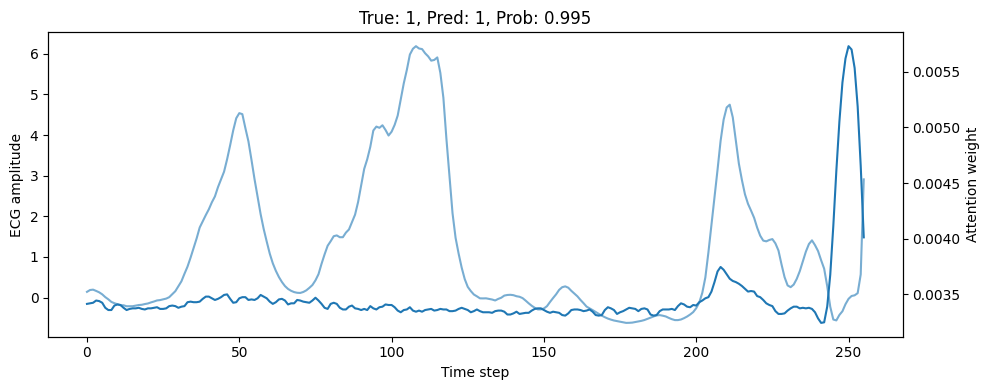

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # choose which test sample to visualize
x = X_test[idx:idx+1]  # shape (1, SEG_LEN, 1)
y_true = y_test[idx]

y_prob = bilstm_model.predict(x, verbose=0).ravel()[0]
y_pred = int(y_prob >= 0.5)

att_weights = att_model.predict(x, verbose=0).ravel()
seq = x[0, :, 0]
t = np.arange(len(seq))

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(t, seq)
ax1.set_xlabel("Time step")
ax1.set_ylabel("ECG amplitude")

ax2 = ax1.twinx()
ax2.plot(t, att_weights, alpha=0.6)
ax2.set_ylabel("Attention weight")

plt.title(f"True: {y_true}, Pred: {y_pred}, Prob: {y_prob:.3f}")
plt.tight_layout()
plt.show()
